In [1]:
import os
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/optuna/study/_optimize.py:29: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


In [2]:
adata = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/zebrafish_new/zebrafish_processed.h5ad")
cts_meso = adata[adata.obs["germ_layer"].isin(["mesoderm", 'mesoderm/neural crest', 'mesoderm/ectoderm'])].obs["cell_type_broad"].unique()

In [3]:
len(cts_meso)

42

In [4]:
data_dir = "/lustre/groups/ml01/workspace/cell_flow_zebrafish/results/single_condition/interpolate_time"

In [5]:
gene_target = "control_control"

In [6]:
df_pert = pd.read_csv(os.path.join(data_dir, f"interpolated_tbx16_control_obs.csv"))

In [7]:
df_pert = df_pert[df_pert["cell_type_broad"].isin(cts_meso)]

In [8]:
df_pert.shape

(366653, 5)

In [9]:
df_pert["logtime"] = df_pert.apply(lambda x: float(x["condition"].split("_")[-1][:4]), axis=1)

In [10]:
df_pert.head(-5)

,Unnamed: 0,condition,cell_type_broad_transfer,cell_type_broad_transfer_score,cell_type_broad,logtime
4,4,tbx16_control_2.8903717578961645,contains head vasculature?,1.0,contains head vasculature?,2.89
21,21,tbx16_control_2.8903717578961645,mesodermal progenitor cells (contains PSM),1.0,mesodermal progenitor cells (contains PSM),2.89
23,23,tbx16_control_2.8903717578961645,head mesenchyme/PA cartilage,1.0,head mesenchyme/PA cartilage,2.89
26,26,tbx16_control_2.8903717578961645,mature fast muscle,1.0,mature fast muscle,2.89
30,30,tbx16_control_2.8903717578961645,red blood cell,1.0,red blood cell,2.89
...,...,...,...,...,...,...
999972,999972,tbx16_control_3.1780538303479453,"endothelium (f8+, clic2+)",1.0,"endothelium (f8+, clic2+)",3.17
999973,999973,tbx16_control_3.1780538303479453,mesodermal progenitor cells (contains PSM),1.0,mesodermal progenitor cells (contains PSM),3.17
999976,999976,tbx16_control_3.1780538303479453,connective tissue-meninges-dermal FB,1.0,connective tissue-meninges-dermal FB,3.17
999978,999978,tbx16_control_3.1780538303479453,fin mesenchyme,1.0,fin mesenchyme,3.17


In [11]:
ct_dists = {}
for lt in df_pert["logtime"].unique():
    df_tmp = df_pert[df_pert["logtime"]==lt]
    ct_tmp = df_tmp["cell_type_broad"].value_counts().to_frame()
    ct_tmp["counts_normalized"] = ct_tmp["count"]/ct_tmp["count"].sum()
    ct_tmp["log_counts_normalized"] = ct_tmp["counts_normalized"]# np.log2(ct_tmp["counts_normalized"]+1+1e-6)
    ct_tmp["norm"] = ct_tmp["log_counts_normalized"]/ct_tmp["log_counts_normalized"].sum()
    ct_tmp["cell_type_broad"] = ct_tmp.index
    ct_dists[lt] = ct_tmp

In [12]:
ct_18_pred = ct_dists[2.89]

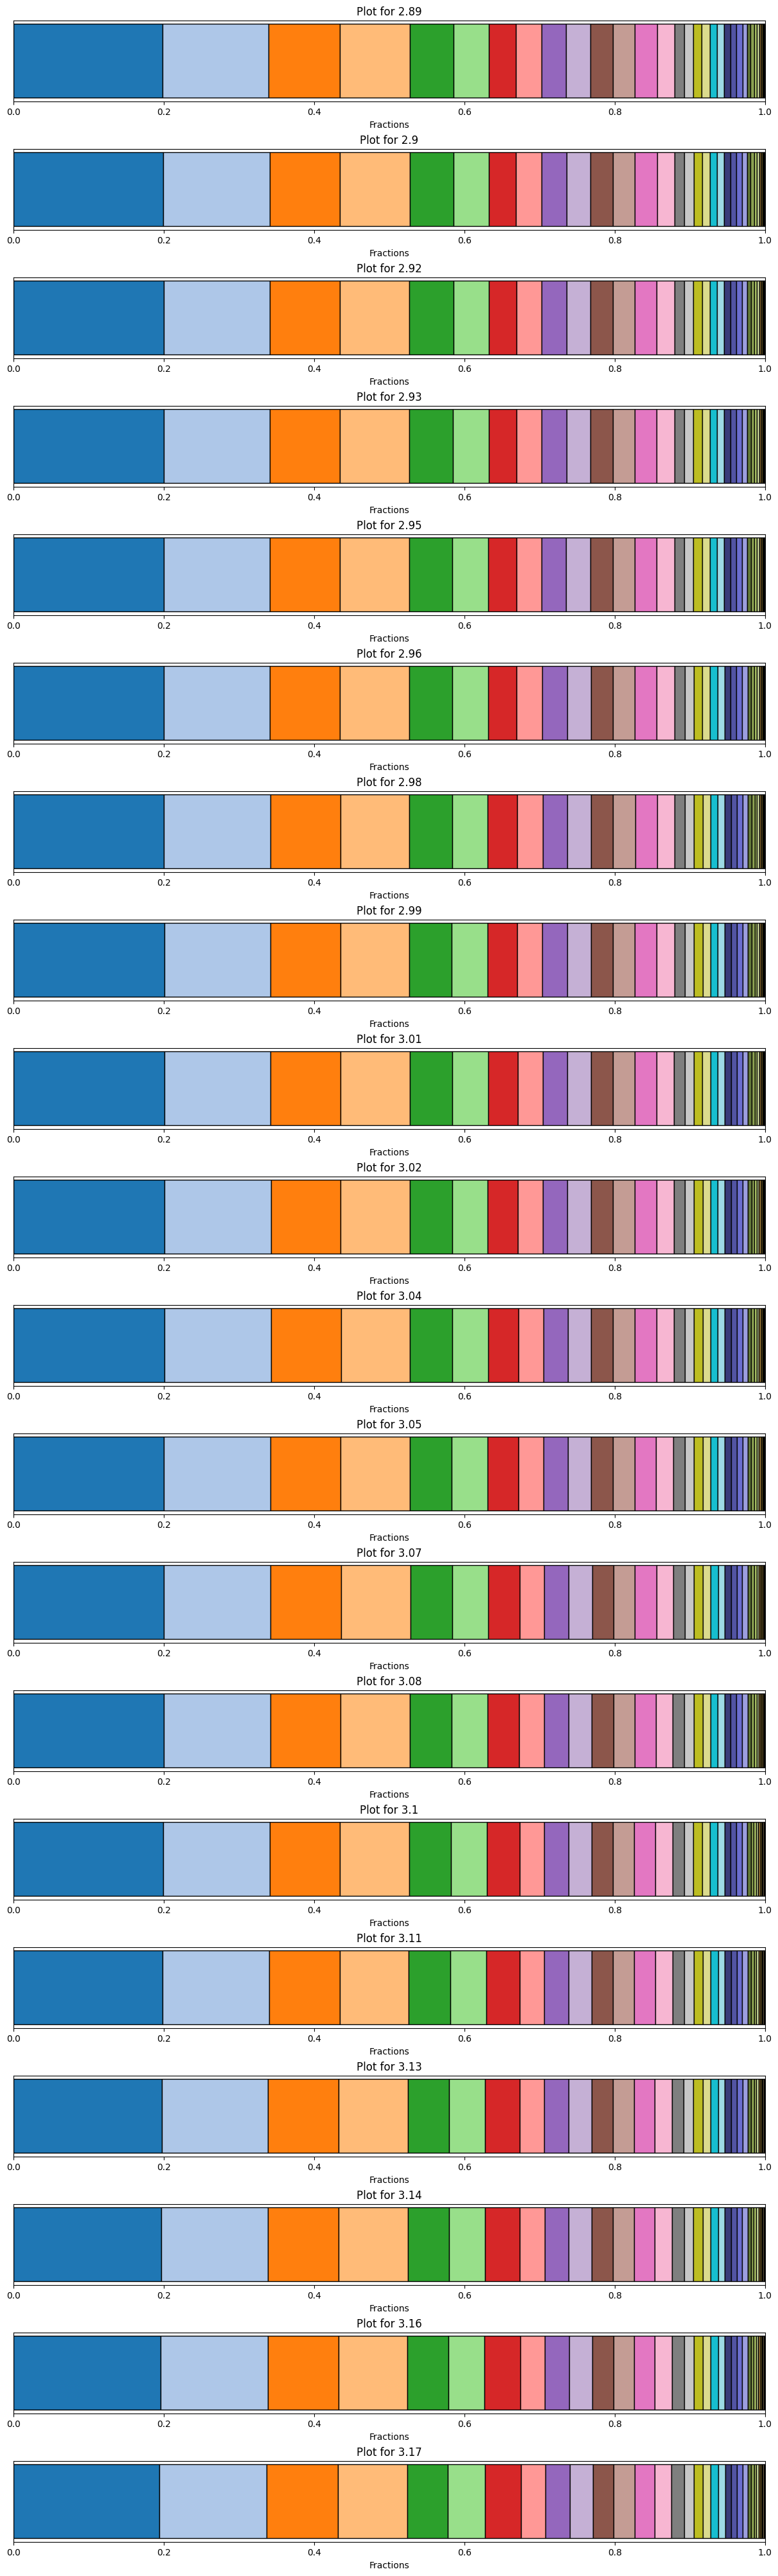

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Example dictionary for demonstration purposes
# Replace with your actual `ct_dists` dictionary

# Total number of plots
n_plots = len(ct_dists)

# Initialize the figure with multiple subplots, one column
fig, axes = plt.subplots(n_plots, 1, figsize=(12, 2 * n_plots), constrained_layout=True)

# Ensure axes is iterable even if there is one subplot
if n_plots == 1:
    axes = [axes]

# Prepare color palettes
colors = list(plt.get_cmap('tab20').colors) + \
         list(plt.get_cmap('tab20b').colors) + \
         list(plt.get_cmap('tab20c').colors)

# Loop through the dictionary and make individual plots
for ax, (name, ct_pred) in zip(axes, ct_dists.items()):
    n_segments = len(ct_pred)
    fractions = ct_pred["norm"].values  # Fraction values
    categories = ct_pred["cell_type_broad"].values  # Categories
    
    # Select colors for this plot
    color_palette = colors[:n_segments]
    
    # Cumulative fractions for positioning
    cumulative = [0] + list(np.cumsum(fractions)[:-1])
    
    # Plot horizontal bar for each fraction
    for i, (frac, color, cat) in enumerate(zip(fractions, color_palette, categories)):
        ax.barh(0, width=frac, left=cumulative[i], color=color, edgecolor='black', label=cat)
    
    # Aesthetics
    ax.set_xlim(0, 1)
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel("Fractions")
    ax.set_title(f"Plot for {name}")  # Title with dictionary key

# Show the figure
plt.show()


In [24]:
ct_dists_true = {}
for t in [18, 24, 36]:
    df_tmp = adata.obs[(adata.obs["timepoint"]==t) & (adata.obs["gene_target"]==gene_target)]
    df_tmp = df_tmp[df_tmp["cell_type_broad"].isin(cts_meso)]
    ct_tmp = df_tmp["cell_type_broad"].value_counts().to_frame()
    ct_tmp["counts_normalized"] = ct_tmp["count"]/ct_tmp["count"].sum()
    ct_tmp["log_counts_normalized"] = np.log2(ct_tmp["counts_normalized"]+1+1e-6)
    ct_tmp["norm"] = ct_tmp["log_counts_normalized"]/ct_tmp["log_counts_normalized"].sum()
    ct_tmp["cell_type_broad"] = ct_tmp.index
    ct_dists_true[np.log(t).round(2)] = ct_tmp

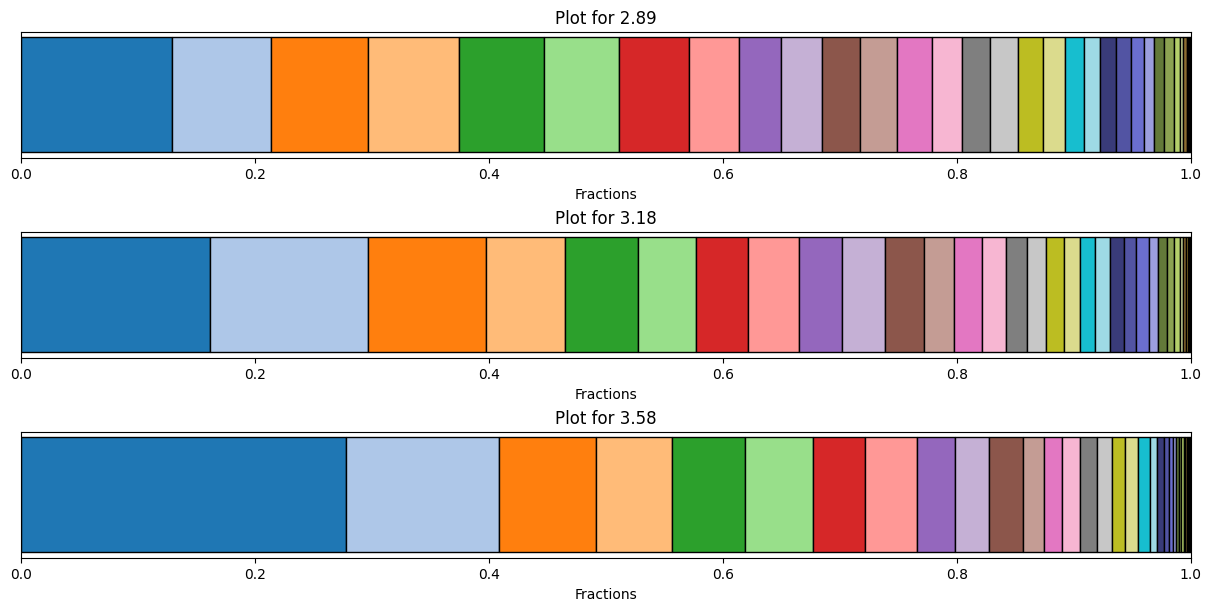

In [25]:
import matplotlib.pyplot as plt
import numpy as np


# Total number of plots
n_plots = len(ct_dists_true)

# Initialize the figure with multiple subplots, one column
fig, axes = plt.subplots(n_plots, 1, figsize=(12, 2 * n_plots), constrained_layout=True)

# Ensure axes is iterable even if there is one subplot
if n_plots == 1:
    axes = [axes]

# Prepare color palettes
colors = list(plt.get_cmap('tab20').colors) + \
         list(plt.get_cmap('tab20b').colors) + \
         list(plt.get_cmap('tab20c').colors)

# Loop through the dictionary and make individual plots
for ax, (name, ct_pred) in zip(axes, ct_dists_true.items()):
    n_segments = len(ct_pred)
    fractions = ct_pred["norm"].values  # Fraction values
    categories = ct_pred["cell_type_broad"].values  # Categories
    
    # Select colors for this plot
    color_palette = colors[:n_segments]
    
    # Cumulative fractions for positioning
    cumulative = [0] + list(np.cumsum(fractions)[:-1])
    
    # Plot horizontal bar for each fraction
    for i, (frac, color, cat) in enumerate(zip(fractions, color_palette, categories)):
        ax.barh(0, width=frac, left=cumulative[i], color=color, edgecolor='black', label=cat)
    
    # Aesthetics
    ax.set_xlim(0, 1)
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel("Fractions")
    ax.set_title(f"Plot for {name}")  # Title with dictionary key

# Show the figure
plt.show()


In [26]:
mat_f_m = {}
for k,v in ct_dists.items():
    mat_f_m[k] = v.loc["mesodermal progenitor cells (contains PSM)"]["norm"]

In [27]:
mat_f_m

{2.89: 0.19817156621229542,
 2.9: 0.19917943107221006,
 2.92: 0.199704304019275,
 2.93: 0.19982485906627995,
 2.95: 0.1998905309250137,
 2.96: 0.20004374931641689,
 2.98: 0.2004590665646519,
 2.99: 0.20067729954118418,
 3.01: 0.2007751514820678,
 3.02: 0.2006659752169878,
 3.04: 0.20069846120266288,
 3.05: 0.20038167938931298,
 3.07: 0.20017444395987788,
 3.08: 0.19989097846824747,
 3.1: 0.19893205470495287,
 3.11: 0.19840060929169842,
 3.13: 0.19730332191594624,
 3.14: 0.19663500678426055,
 3.16: 0.19588691735851108,
 3.17: 0.1943480147537427}

In [20]:
v.loc["mature slow muscle"]

count                                   909
counts_normalized                  0.049306
log_counts_normalized              0.049306
norm                               0.049306
cell_type_broad          mature slow muscle
Name: mature slow muscle, dtype: object

In [21]:
mat_f_m_true = {}
for k,v in ct_dists_true.items():
    mat_f_m_true[k] = v.loc["mesodermal progenitor cells (contains PSM)"]["norm"]

In [22]:
mat_f_m_true 

{2.89: 0.0848547310561445,
 3.18: 0.024299514009719806,
 3.58: 0.00022385315233207018}

In [23]:
mat_f_m

{2.89: 0.19817156621229542,
 2.9: 0.19917943107221006,
 2.92: 0.199704304019275,
 2.93: 0.19982485906627995,
 2.95: 0.1998905309250137,
 2.96: 0.20004374931641689,
 2.98: 0.2004590665646519,
 2.99: 0.20067729954118418,
 3.01: 0.2007751514820678,
 3.02: 0.2006659752169878,
 3.04: 0.20069846120266288,
 3.05: 0.20038167938931298,
 3.07: 0.20017444395987788,
 3.08: 0.19989097846824747,
 3.1: 0.19893205470495287,
 3.11: 0.19840060929169842,
 3.13: 0.19730332191594624,
 3.14: 0.19663500678426055,
 3.16: 0.19588691735851108,
 3.17: 0.1943480147537427}

In [30]:
import json
with open("/lustre/groups/ml01/workspace/ot_perturbation/data/zebrafish_new/nervous_targets", "r") as file:
    data = json.load(file)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte